# Least squares
We've learned a bit about least squares in class. Let's see it in action

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, solve
from scipy.optimize import minimize
from numpy.random import seed, randn

## A first order example
Here's some noisy data:

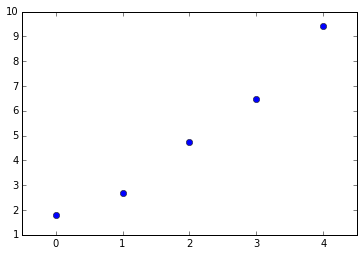

In [2]:
seed(1)
xs = np.array(list(range(5)))
ys = [2*x+1 + randn()/2 for x in xs]
plt.plot(xs,ys,'o')
ax = plt.gca()
ax.set_xlim(-0.5,4.5);

Let's use `scipy.optimize.minimize` to fit a function of the form $f(x)=ax+b$ to the data. This closely mirrors the way we might use calculus to do this.

In [3]:
def f(ab):
    a = ab[0]
    b = ab[1]
    return sum([((a*xs[i]+b)-ys[i])**2 for i in range(len(xs))])
result = minimize(f,[2,1])
if result['success'] == True:
    print(result['x'])

[ 1.9010456   1.22559441]


I guess this means that $f(x) \approx 1.901x+1.2256$ should closely fit the data. Let's have a look.

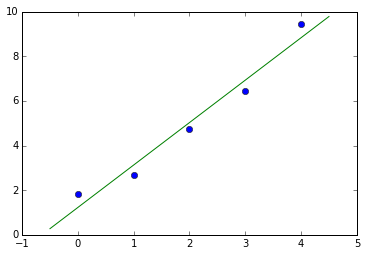

In [4]:
a = result['x'][0]
b = result['x'][1]
def f(x): return a*x+b
plt.plot(xs,ys,'o')
xxs = np.linspace(min(xs)-0.5,max(xs)+0.5,20)
yys = f(xxs)
plt.plot(xxs,yys)

Naturally, SciPy has built in functions for this purpose. It's a bit tricky to understand the input, unless you've got a grip on the normal equations. This involves the matrix $A$ whose columns are the constant powers of the $x$-data. There are $n$ columns, if we're using $n$ functions. There are $m$ rows, if we're fitting $m$ points. For this example, we have
$$A = \left(\begin{array}{cc}
 0 & 1 \\
 1 & 1 \\
 2 & 1 \\
 3 & 1 \\
 4 & 1 \\
\end{array}\right).$$
We can construct this matrix pretty easily using `numpy`'s `vstack` command, together with a `transpose`.

In [5]:
A = np.vstack([xs, xs**0]).transpose()
A

array([[0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1]])

Once we have this, it's just a matter of applying the `lstsq` function to get the coefficients.

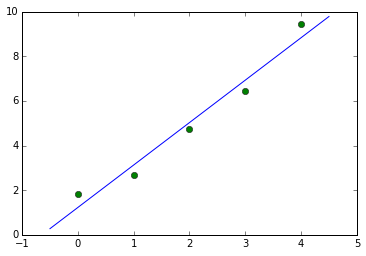

In [6]:
m,b = lstsq(A, ys)[0]
def ff(x): return m*x+b
yys = ff(xxs)
plt.plot(xxs,yys)
plt.plot(xs,ys,'o')

It's worth understanding that the coefficients (originally computed back in `In[3]` can be computed as follows:

In [7]:
solve(A.transpose().dot(A), A.transpose().dot(ys))

array([ 1.90104562,  1.22559439])

## A higher degree example
Let's use the normal equations to fit a cubic to more complicated data.

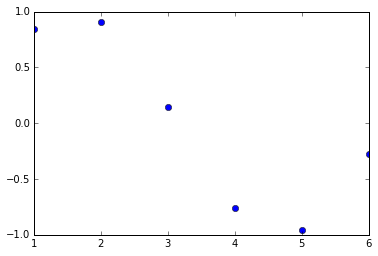

In [41]:
xs = np.arange(1,7)
ys = np.sin(xs)
plt.plot(xs,ys,'o')

It seems like a cubic might fit that well.

poly1d([ 0.10245194, -0.98069833,  2.23648236, -0.50119015])

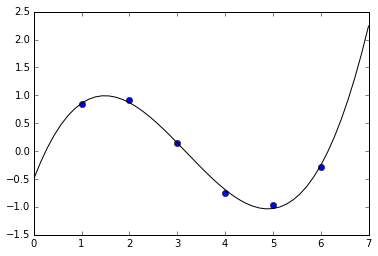

In [42]:
A = np.vstack([xs**3, xs**2, xs**1, xs**0]).transpose()
coeffs = np.linalg.lstsq(A, ys)[0]
p = np.poly1d(coeffs)
xxs = np.linspace(0,7)
yys = p(xxs)
plt.plot(xs,ys,'o')
plt.plot(xxs,yys, 'k')
p

In [10]:
solve(A.transpose().dot(A), A.transpose().dot(ys))

array([ 0.10245194, -0.98069833,  2.23648236, -0.50119015])

## A by hand example
You might consider how to fit the following data with a line.

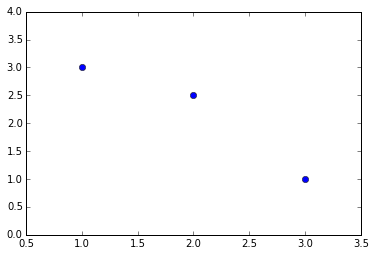

In [11]:
data = [(1,3), (2,2.5), (3,1)]
xs = [d[0] for d in data]
ys = [d[1] for d in data]
plt.plot(xs,ys, 'o')
ax = plt.gca()
ax.set_xlim(0.5,3.5)
ax.set_ylim(0,4);

I guess we need $f(x)=ax+b$ where $a$ and $b$ minimize the following function $F$.

\begin{align}
F(a,b) &= (a\times1+b-3)^2 + (a\times2+b-2.5)^2 + (a\times3+b-1)^2 \\
\frac{\partial F}{\partial a} &= 2(a+b-3) + 4(2a+b-2.5) + 6(3a+b-1) = 28a + 12b - 22 = 0 \\
\frac{\partial F}{\partial b} &= 2(a+b-3) + 2(2a+b-2.5) + 2(3a+b-1) = 12a + 6b - 13 = 0
\end{align}
Turns out that $a=-1$ and $b=25/6$.

### Alternative basis functions
The functions $1,x,x^2,\ldots,x^{n-1}$ can be thought of as a *basis* for the set of polynomials. We might want to approximate data with another kind of function, however. Suppose, for example, we wish approxmiate the following data:

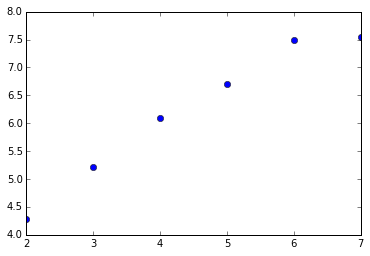

In [23]:
seed(1)
xs = np.array(list(range(2,8)))
ys = [2+3*np.log(x) + randn()/8 for x in xs]
plt.plot(xs,ys,'o')

It might make sense to use a function of the form $f(x) = a+b\log(x)$. We can do so by direct minmization.

In [18]:
def squares(ab):
    a = ab[0]
    b = ab[1]
    return sum([((a + b*np.log(xs[i]))-ys[i])**2 for i in range(len(xs))])
result = minimize(squares,[2,3])
result

      jac: array([  9.31322575e-10,  -2.60770321e-08])
        x: array([ 2.29494   ,  2.76273465])
      nit: 3
     njev: 5
   status: 0
 hess_inv: array([[ 1.01504143, -0.65573522],
       [-0.65573522,  0.46150579]])
  success: True
      fun: 0.09222459111186312
     nfev: 20
  message: 'Optimization terminated successfully.'

The value of `result['x']` indicates that $2.29+2.76\log(x)$ oughtta approximate our data fairly well. We can can get this same result more efficiently using our projector matrix.

In [36]:
A = np.vstack([np.ones(len(xs)), np.log(xs)]).transpose()
solution = solve(A.transpose().dot(A), A.transpose().dot(ys))
print(A)
print('-------')
print(solution)

[[ 1.          0.69314718]
 [ 1.          1.09861229]
 [ 1.          1.38629436]
 [ 1.          1.60943791]
 [ 1.          1.79175947]
 [ 1.          1.94591015]]
-------
[ 2.29493997  2.76273468]


Or, equivalently, the `lsqsq` command.

In [29]:
lstsq(A, ys)[0]

array([ 2.76273468,  2.29493997])

In any event, here's how it looks:

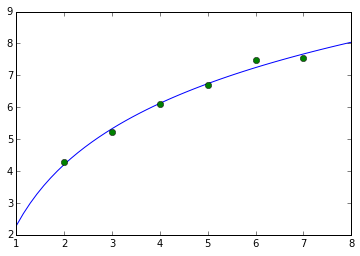

In [35]:
a,b = result['x']
def ff(x): return a + b*np.log(x)
xxs = np.linspace(1,8)
yys = ff(xxs)
plt.plot(xxs,yys)
plt.plot(xs,ys,'o')